# ADS 504 Initial Work

In [ ]:

import re

import pandas as pd
import numpy as np

import folium
from folium.plugins import MarkerCluster

import plotly.express as px

from collections import Counter, defaultdict
from string import punctuation

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, cross_val_score

from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud


from tqdm.auto import tqdm

import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords


nlp = spacy.load("en_core_web_sm")



In [ ]:
# This is Katie giving the program access to the data...it won't read it the other way!
# We can take this snippet out when we need to
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Reading in the Data

In [ ]:
data_location = "/content/drive/MyDrive/ADS 504 Project/missing_persons_clean.csv"

missing = pd.read_csv(data_location)

In [ ]:
missing.head()

,name,description,long,lat,location
0,NamUs #UP4795 ME/C Case Number GC99-158 604UFMN,"date found: November 4, 1999location: Red Wing...",-92.541061,44.565821,POINT(-92.5410605 44.5658215)
1,NamUs #UP4804 ME/C Case Number 39918 849UFMN,"date found: July 20, 1977location: St. Paul, M...",-93.055401,44.941109,POINT(-93.0554009 44.9411089)
2,NamUS #UP4808 ME/C Case Number 00-1411 270UFMN,NaN,-93.194060,45.078014,POINT(-93.1940597 45.0780144)
3,NamUs #UP4796 ME/C Case Number GC07-39 102UFMN,"date found: March 26, 2007location: Treasure I...",-92.641182,44.635803,POINT(-92.6411819 44.6358033)
4,NamUs #UP6525 ME/C Case Number FC08-61 803UFMN,"date found: August 10, 2008location: Mabel, Mi...",-91.773434,43.520049,POINT(-91.7734337 43.5200495)


## Splitting the description column

In [ ]:
start = '^.*'
end = '.*'

col1 = 'location'
col2 = 'age est'
col3 = 'race'
col4 = 'height'
col5 = 'weight'
col6 = 'description'

In [ ]:
date = []
for row in range(len(missing)):
    description = missing['description'][row]
    info = re.sub(col1+end, '', str(description))
    data_clean = re.sub('date found: ', '', info)
    date.append(data_clean)
date = pd.DataFrame(date)

location = []
for row in range(len(missing)):
    description = missing['description'][row]
    info = re.sub(start+col1, '', str(re.sub(col2+end, '', str(description))))
    data_clean = re.sub('location: ', '', info)
    data_clean2 = re.sub(':', '', data_clean)
    location.append(data_clean2)
location = pd.DataFrame(location)

age_est = []
for row in range(len(missing)):
    description = missing['description'][row]
    info = re.sub(start+col2, '', str(re.sub(col3+end, '', str(description))))
    data_clean = re.sub('age est.:', '', info)
    data_clean2 = re.sub('.:', '', data_clean)
    age_est.append(data_clean2)
age_est = pd.DataFrame(age_est)

race= []
for row in range(len(missing)):
    description = missing['description'][row]
    info = re.sub(start+col3, '', str(re.sub(col4+end, '', str(description))))
    data_clean = re.sub('race: ', '', info)
    data_clean2 = re.sub(':', '', data_clean)
    race.append(data_clean2)
race = pd.DataFrame(race)

height = []
for row in range(len(missing)):
    description = missing['description'][row]
    info = re.sub(start+col4, '', str(re.sub(col5+end, '', str(description))))
    data_clean = re.sub('height: ', '', info)
    data_clean2 = re.sub(':', '', data_clean)
    height.append(data_clean2)
height = pd.DataFrame(height)

weight = []
for row in range(len(missing)):
    description = missing['description'][row]
    info = re.sub(start+col5, '', str(re.sub(col6+end, '', str(description))))
    data_clean = re.sub('weight: ', '', info)
    data_clean2 = re.sub(':', '', data_clean)
    weight.append(data_clean2)
weight = pd.DataFrame(weight)

desc = []
for row in range(len(missing)):
    description = missing['description'][row]
    info = re.sub(start+col6, '', str(description))
    data_clean = re.sub('description: ', '', info)
    data_clean2 = re.sub(':', '', data_clean)
    desc.append(data_clean2)

description = pd.DataFrame(desc)

## Creating the preliminary dataset

In [ ]:
cleaned = pd.DataFrame()

cleaned['index_v'] = missing.index
cleaned['name'] = missing['name']
cleaned['date'] = date
cleaned['location'] = location
cleaned['age_est'] = age_est
cleaned['race'] = race
cleaned['height'] = height
cleaned['weight'] = weight
cleaned['description'] = description
cleaned['long'] = missing['long']
cleaned['lat'] = missing['lat']


In [ ]:
missing_str = ['', ' ', 'nan']

for item in missing_str:
    cleaned = cleaned.replace(item, np.nan)

## Updating the date column

In [ ]:
date = []
for index in cleaned.index:
    orig = str(cleaned['date'][index])
    char = len(orig)
    if char < 30:
        date.append({'index_v': index, 'date_pull': orig})
    else:
        date_pull = re.search('((January|February|March|April|May|June|July|August|September|October|November|December) [0-9]{1,2}, [0-9]{4})',str(cleaned['description'][index]))
        date_pull2 = re.search('((January|February|March|April|May|June|July|August|September|October|November|December) [0-9]{1,2}, [0-9]{4})',str(cleaned['name'][index]))
        date_pull3 = re.search('((January|February|March|April|May|June|July|August|September|October|November|December) [0-9]{1,2}, [0-9]{4})',str(cleaned['date'][index]))
        if date_pull:
            date_pull = date_pull.group()
            date.append({'index_v': index, 'date_pull':date_pull})
        elif date_pull2:
            date_pull2 = date_pull2.group()
            date.append({'index_v': index, 'date_pull': date_pull2})
        elif date_pull3:
            date_pull3 = date_pull3.group()
            date.append({'index_v': index, 'date_pull': date_pull3})
        else:
            date.append({'index_v': index, 'date_pull': "no match found"})

dates = pd.DataFrame(date)
dates[dates['date_pull']=='nan'] = np.nan

# replace date column in original df with dates
for row in range(len(cleaned)):
    cleaned.loc[row, 'date'] = dates['date_pull'][row]

## Updating the age column

In [ ]:

ages=[]

for row in range(len(cleaned)):
    item = str(cleaned['age_est'][row])
    text = re.search(r'(month)|(Adult)|(newborn)|(fetus)', item)
    orig = re.search(r'(\d{1,2} - \d{1,2})|(\d{1,2}-\d{1,2})', item)
    age_pull = re.search(r'(\d{1,2} to \d{1,2})|(\d{1,2}-\d{1,2} year)', str(cleaned['name'][row]))
    age_pull2 = re.search(r'age \d{1,2}',str(cleaned['date'][row]))

    if text:
        ages.append({'index_v': row, 'age_low':item, 'age_high': item})

    elif orig:
        age = re.findall(r'\d{1,2}', item)
        ages.append({'index_v': row, 'age_low': age[0], 'age_high': age[1]})

    elif age_pull:
        age = re.findall(r'\d{1,2}', str(cleaned['name'][row]))
        ages.append({'index_v': row, 'age_low': age[0], 'age_high': age[1]})

    elif age_pull2:
        age = re.findall(r'\d{1,2}', str(cleaned['date'][row]))
        ages.append({'index_v': row, 'age_low': age, 'age_high':age})

    else:
        ages.append({'index_v': row, 'age_low': np.nan, 'age_high': np.nan})


ages = pd.DataFrame(ages)

# replace date column in original df with dates
for row in range(len(cleaned)):
    cleaned.loc[row, 'age_low'] = ages['age_low'][row]
    cleaned.loc[row, 'age_high'] = ages['age_high'][row]

cleaned = cleaned.drop('age_est', axis = 1)

## Updating the race column

In [ ]:
races = []

for item in range(len(cleaned['race'].unique())):
    race = str(cleaned['race'].unique()[item])
    split = race.split("','")
    for a in split:
        a = str(a)
        split2 = a.split(",")
        for b in split2:
            b = str(b)
            c = re.sub("'", '', b)
            races.append(c)

r = pd.DataFrame(races)
r.columns = ['race']


list = "'"
start = "("
end = ")|"

for item in range(len(r['race'].unique())):
    race = str(r['race'].unique()[item])
    race = race[1:]
    reg =  start+race+end
    list += reg
list+= '"'

races=[]

for index in cleaned['name'].index:
    orig = re.search(r'.*',str(cleaned['race'][index]))
    race = re.search(list,str(cleaned['name'][index]))
    if orig:
        race_pull = str(cleaned['race'][index])
        races.append({'index_v':index, 'race_pull':race_pull})
    elif race:
        race_pull = race.group()
        races.append({'index_v': index, 'race_pull':race})
    else:
        races.append({'index_v': index, 'race_pull': "no match found"})

races = pd.DataFrame(races)

# replace date column in original df with dates
for row in range(len(cleaned)):
    cleaned.loc[row, 'race'] = races['race_pull'][row]

## Cleaning the height column and converting everything to inches

In [ ]:
heights = []

for row in range(len(cleaned)):
    item = str(cleaned['height'][row])
    item = item[:5]
    heights.append(item)


height2 = []

for item in heights:
    height = re.sub("'", " feet ", item)
    height = re.sub('"', "", height)
    height = re.sub('^ ', '', height)
    height2.append(height)

h = []
for item in height2:
    is_ft = re.search(r'(feet)', item)
    if is_ft:
        item = item + ' inches'
        feet = int(item[:1])
        inch = item[7:]
        inch = int(item[:1])
        total = (feet*12) + inch
    else:
        height = re.search(r'\d{2,3}', item)
        if height:
            cm = height.group(0)
            total = int(cm) * 0.393701
        else:
            total = np.nan

    h.append({'height_in': total})


height_df = pd.DataFrame(h)

for row in range(len(cleaned)):
    cleaned.loc[row, 'height'] = height_df['height_in'][row]



## Cleaning the weight column

In [ ]:
weight_n = []

for index in cleaned.index:
    weight = re.sub(r'lbs.*', '', str(cleaned['weight'][index]))
    is_n = re.search(r'\d{1,3}', weight)

    if is_n:
        total = int(re.findall(r'\d{1,3}', weight)[0])
    else:
        total = np.nan

    weight_n.append({'weight_n': total})

weight_n = pd.DataFrame(weight_n)

for row in range(len(cleaned)):
    cleaned.loc[row, 'weight'] = weight_n['weight_n'][row]


## Cleaning the location column

In [ ]:
for row in range(len(cleaned)):
    cleaned.loc[row, 'location'] = re.sub(r'age.*', '', str(cleaned['location'][row]))

In [ ]:
for row in range(len(cleaned)):
    date = r'((January|February|March|April|May|June|July|August|September|October|November|December) [0-9]{1,2}, [0-9]{4})'
    url = r'http.*(informationlinks|html|pdflinks|\d{4,5}|nav)'
    unknown = r'[^\x00-\x7F]+'
    link_str = r'\s{0,1}links\s{0,1}'
    exact = r'(\(exact location not given\)|\(exact coordinates\)|\(exact location in county not given\))'

    string = re.sub(date, '', str(cleaned['description'][row]))
    string = re.sub(url, '', string)
    string = re.sub(unknown, '', string)
    string = re.sub(r'^(\s|\.)$', '', string)
    string = re.sub(exact, '', string)

    cleaned.loc[row, 'description'] = re.sub(link_str, '', string)

In [ ]:
print('Status of individuals in Cleaned Dataset', cleaned['status'].value_counts())

Status of individuals in Cleaned Dataset status
unknown          12887
missing           3000
remains_found     1420
Name: count, dtype: int64


## Looking at the distribution of missing data

In [ ]:
cleaned = cleaned.replace('nan', np.nan)
cleaned = cleaned.replace('no match found', np.nan)

cleaned.isnull().sum()

,0
index_v,0
name,0
date,9347
location,8844
race,11928
height,12162
weight,13438
description,2504
long,0
lat,0


In [ ]:
cleaned[['name', 'date', 'location', 'race', 'age_low', 'age_high', 'description','long','lat']].isnull().sum()

,0
name,0
date,9347
location,8844
race,11928
age_low,13761
age_high,13761
description,2504
long,0
lat,0


In [ ]:
cleaned.shape

(17307, 13)

In [ ]:
races = cleaned[['race', 'description']].dropna()

white = []
non_white = []

for index in races.index:
    race = str(races['race'][index])
    desc = str(races['description'][index])

    mixed = re.search(r',', race)

    is_white = re.search(r'^\s{1}(white|White|White\s{0,1}/\s{0,1}Caucasian|Caucasian / White)', race)

    if mixed:
        non_white.append({'index': index, 'description': desc})
    elif is_white:
        white.append({'index': index, 'description': desc})
    else:
        continue

white_df = pd.DataFrame(white)
non_white_df = pd.DataFrame(non_white)

print('Count of White Individuals', white_df.shape[0])
print('Count of Non-White Individuals', non_white_df.shape[0])
print('White to Non-White Ratio: ', white_df.shape[0]/non_white_df.shape[0])

Count of White Individuals 2888
Count of Non-White Individuals 213
White to Non-White Ratio:  13.55868544600939


In [ ]:
no_na = cleaned[['name', 'date', 'location', 'race', 'age_low', 'age_high', 'description','long','lat']].dropna()
no_na

,name,date,location,race,age_low,age_high,description,long,lat
0,NamUs #UP4795 ME/C Case Number GC99-158 604UFMN,"November 4, 1999","Red Wing, Minnesota",Caucasian / White,0-12 months,0-12 months,A full term infant with umbilical cord still ...,-92.541061,44.565821
1,NamUs #UP4804 ME/C Case Number 39918 849UFMN,"July 20, 1977","St. Paul, Minnesota",Caucasian / White,16,30,Medium length brown hair with brown or green ...,-93.055401,44.941109
3,NamUs #UP4796 ME/C Case Number GC07-39 102UFMN,"March 26, 2007","Treasure Island Marina, Red Wing, Minnesota",Caucasian / White,0-12 months,0-12 months,The infant was found in the Buffalo Slough of...,-92.641182,44.635803
4,NamUs #UP6525 ME/C Case Number FC08-61 803UFMN,"August 10, 2008","Mabel, Minnesota",African American / Black,30,40,The skull has been stored in the school since...,-91.773434,43.520049
5,NamUs #UP4874 ME/C Case Number 742535 894UFOK,"August 5, 1974","Norman, Oklahoma",Uncertain - Caucasian / White with possible N...,30,50,The decomposed remains of the victim were fou...,-97.317238,35.245970
...,...,...,...,...,...,...,...,...,...
16840,Adelaie Grace Morgan,"May 1, 2020","Dayton, OH",Biracial (Black and white),"Nicknames / Aliase dat May 1, 2020locatio Dayt...","Nicknames / Aliase dat May 1, 2020locatio Dayt...",Adelaie Morgan was last seen at the Knights I...,-84.188055,39.856856
17195,Tracy Forde,"December 12, 2006","Toronto, ON",Black,12,20,"On , Tracy Forde was seen for the last time a...",-79.383148,43.653261
17208,Emabit Yelma Yafru,"January 11, 1990","Toronto, ON",Black (Ethiopian),9,19,"On , Emabit Yafru travelled from Ethiopia to ...",-79.384273,43.653753
17299,Naomi Collins,"March 5, 2015","Sumter, SC",White,5,20,"Last seen on March 5th, 2015 on Pinewood Road...",-80.389234,33.884500


In [ ]:
for index in no_na.index:
    age_low = str(no_na['age_low'][index])
    age_high = str(no_na['age_high'][index])
    is_ch = re.search(r'[^\d]', age_high)
    if is_ch:
        value = age_high
        is_inf = re.search(r'month', value)
        is_f = re.search(r'newborn|fetus', value)
        is_adult_pre = re.search(r'(A|a)dult.{1,3}(P|p)re', value)
        is_range = re.search(r'\d{2}-\d{2}', value)
        is_adult = re.search(r'^ Adult$', value)
        is_lt_ya = re.search(r'Teen - Young', value)
        if is_inf:
            age_low = 0
            age_high = 1
        elif is_f:
            age_low = 0
            age_high = 0
        elif is_adult_pre:
            high = int(re.search(r'\d{2}', value).group())
            age_low = 18
            age_high = high
        elif is_range:
            age = re.findall(r'\d{2}', value)
            age_low = int(age[0])
            age_high=int(age[0])
        elif is_adult:
            age_low = 18
            age_high = 90
        elif is_lt_ya:
            age_low = 17
            age_high = 23
        else:
            age_low = 'no age found'
            age_high = 'no age found'
    else:
        age_low = no_na['age_low'][index]
        age_high = no_na['age_high'][index]

    no_na.loc[index, 'age_low'] = age_low
    no_na.loc[index, 'age_high'] = age_high

In [ ]:
for index in no_na.index:
    no_na.loc[index, 'date'] = str(no_na['date'][index])

In [ ]:
for index in no_na.index:
    unknown = r'[^\x00-\x7F]+'
    date_form = re.sub(unknown, '', no_na['date'][index])
    date_form = re.sub(r'\s$', '', date_form)

    is_bdy = re.search(r'((January|February|March|April|May|June|July|August|September|October|November|December) [0-9]{1,2}, [0-9]{4})', date_form)
    is_ymd = re.search(r'\d{4}-\d{1,2}-\d{1,2}', date_form)
    is_mdy = re.search(r'\d{1,2}/\d{1,2}/\d{4}', date_form)
    is_dmy = re.search(r'%d %B %Y', date_form)

    if is_bdy:
        date_form = is_bdy.group()
        date_form = datetime.strptime(date_form, "%B %d, %Y").date()
    elif is_ymd:
        date_form = datetime.strptime(date_form, "%Y-%m-%d").date()
    elif is_mdy:
        date_form = datetime.strptime(date_form, "%m/%d/%Y").date()
    elif is_dmy:
        date_form = datetime.strptime(date_form, "%d %M %Y").date()
    else:
        date_form = 'fix format'
    no_na.loc[index, 'date'] = date_form


## Looking for unique tokens

In [ ]:
punctuation = set(punctuation) # speeds up comparison

def remove_punctuation(text, punct_set=punctuation) :
    return("".join([ch for ch in text if ch not in punct_set]))

def clean(data, col, sw):
    text = ' '.join(data[col])
    # Remove punctuation
    text = remove_punctuation(text)
    # Convert to lowercase and split into words
    words = str(text).lower().split()
    # Remove stopwords
    cleaned_tokens = [word for word in words if word not in sw]
    return cleaned_tokens

In [ ]:
description = cleaned[['race', 'description']].dropna()

In [ ]:
white_corpus = []
non_white_corpus = []

for index in description.index:
    race = str(description['race'][index])
    desc = str(description['description'][index])

    mixed = re.search(r',', race)

    is_white = re.search(r'^\s{1}(white|White|White\s{0,1}/\s{0,1}Caucasian|Caucasian / White)', race)

    if mixed:
        non_white_corpus.append({'index': index, 'description': desc})
    elif is_white:
        white_corpus.append({'index': index, 'description': desc})
    else:
        continue

white_corpus = pd.DataFrame(white_corpus)
non_white_corpus = pd.DataFrame(non_white_corpus)

In [ ]:
print('Count of White Individuals', white_corpus.shape[0])
print('Count of Non-White Individuals', non_white_corpus.shape[0])
print('White to Non-White Ratio: ', white_corpus.shape[0]/non_white_corpus.shape[0])

Count of White Individuals 2888
Count of Non-White Individuals 213
White to Non-White Ratio:  13.55868544600939


In [ ]:
white = clean(white_corpus, 'description', stopwords)
non_white = clean(non_white_corpus, 'description', stopwords)

In [ ]:
def get_count(tokens):
    df = pd.DataFrame.from_records(Counter(tokens).most_common(), columns=['token','count'])
    df['concentration'] = df['count']/sum(df['count'])
    return(df[df['count']> 5])

In [ ]:
def sort(data, sort_col, comp_col):
    data = data[data[sort_col] > data[comp_col]]
    data = data.sort_values(by=sort_col, ascending=False).head(10)
    return data[['token', sort_col, comp_col]]

In [ ]:
w_corpus = get_count(white)

nw_corpus = get_count(non_white)

comp = pd.merge(w_corpus, nw_corpus, on=['token'], how='inner' )
comp['ratio_w_over_nw'] = comp['concentration_x']/comp['concentration_y']
comp['ratio_nw_over_w'] = comp['concentration_y']/comp['concentration_x']

In [ ]:
print('Words with Higher Ratio in White Corpus than Non-White Corpus \n', sort(comp, 'ratio_w_over_nw', 'ratio_nw_over_w'))
print('Words with Higher Ratio in Non-White Corpus than White Corpus \n', sort(comp, 'ratio_nw_over_w', 'ratio_w_over_nw'))

Words with Higher Ratio in White Corpus than Non-White Corpus 
             token  ratio_w_over_nw  ratio_nw_over_w
2   disappearance         5.972285         0.167440
21           said         3.227260         0.309860
6           heard         3.128958         0.319595
33          later         2.657234         0.376331
4            case         2.090300         0.478400
5            time         2.071850         0.482660
24            day         2.013843         0.496563
14         family         2.006836         0.498297
25       reported         1.996532         0.500868
27         stated         1.979221         0.505249
Words with Higher Ratio in Non-White Corpus than White Corpus 
         token  ratio_nw_over_w  ratio_w_over_nw
200  hispanic        36.371709         0.027494
199      gila        34.660099         0.028852
198      bend        34.660099         0.028852
202    carmen        24.757214         0.040392
201    native        19.255611         0.051933
197     exac

## Topic Modeling

In [ ]:
# This function comes from the BTAP repo.
def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

def wordcloud_topics(model, features, no_top_words=40):
    for topic, words in enumerate(model.components_):
        size = {}
        largest = words.argsort()[::-1] # invert sort order
        for i in range(0, no_top_words):
            size[features[largest[i]]] = abs(words[largest[i]])
            wc = WordCloud(background_color="white", max_words=100,
                       width=960, height=540)
        wc.generate_from_frequencies(size)
        plt.figure(figsize=(6,6))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")

In [ ]:
# Creating Vectorizers
tfidf_text_vectorizer_f = TfidfVectorizer(stop_words="english", min_df=5, max_df = 0.9)
tfidf_text_vectorizer_w = TfidfVectorizer(stop_words="english", min_df=5, max_df = 0.9)
tfidf_text_vectorizer_nw = TfidfVectorizer(stop_words="english", min_df=5, max_df = 0.9)

# Fitting Vectorizers to Full Corpus
tfidf_text_vectors_f = tfidf_text_vectorizer_f.fit_transform(description['description'])

# Fitting Vectorizers to Corpus of White Individuals
tfidf_text_vectors_w = tfidf_text_vectorizer_w.fit_transform(white_corpus['description'])

# Fitting Vectorizers to Corpus of Non-White Individuals
tfidf_text_vectors_nw = tfidf_text_vectorizer_nw.fit_transform(non_white_corpus['description'])

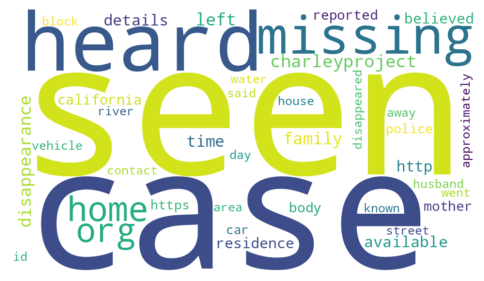

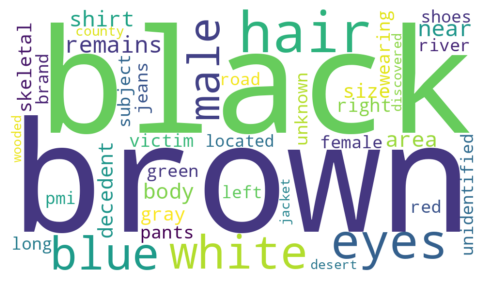

In [ ]:
lda_text_model = LatentDirichletAllocation(n_components = 2, random_state=314)
W_text_matrix = lda_text_model.fit_transform(tfidf_text_vectors_f)
H_lda_text_matrix = lda_text_model.components_

wordcloud_topics(lda_text_model, tfidf_text_vectorizer_f.get_feature_names_out())

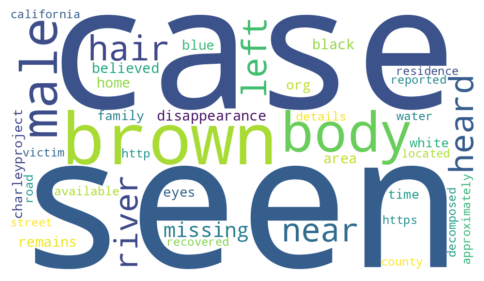

In [ ]:
lda_text_model = LatentDirichletAllocation(n_components = 1, random_state=314)
W_text_matrix = lda_text_model.fit_transform(tfidf_text_vectors_w)
H_lda_text_matrix = lda_text_model.components_

wordcloud_topics(lda_text_model, tfidf_text_vectorizer_w.get_feature_names_out())

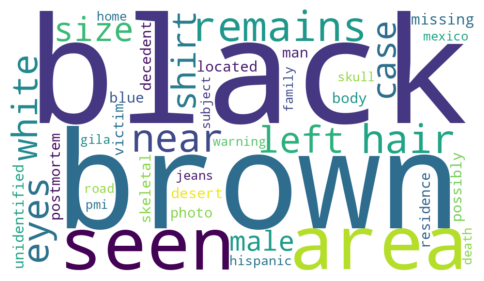

In [ ]:
lda_text_model = LatentDirichletAllocation(n_components = 1, random_state=314)
W_text_matrix = lda_text_model.fit_transform(tfidf_text_vectors_nw)
H_lda_text_matrix = lda_text_model.components_

wordcloud_topics(lda_text_model, tfidf_text_vectorizer_nw.get_feature_names_out())

## Heat Map of lat/long

In [ ]:
print(no_na.columns)
print(no_na.shape)

Index(['name', 'date', 'location', 'race', 'age_low', 'age_high',
       'description', 'long', 'lat'],
      dtype='object')
(2053, 9)


In [ ]:
# In order to try and create a "status" column (of either missing or remains found),
# I'm identifying key forensic words for the two categories
missing_keywords = [
    "last seen", "disappeared", "not been located", "has not been found",
    "remains missing", "still missing", "vanished", "unaccounted for"
]

found_keywords = [
    "remains found", "body found", "located deceased", "skeletal remains",
    "recovered remains", "confirmed deceased", "found dead", "discovered", "unidentified remains"
]


In [ ]:
def infer_status(text):
    text = str(text).lower()
    if any(kw in text for kw in found_keywords):
        return 'remains_found'
    elif any(kw in text for kw in missing_keywords):
        return 'missing'
    else:
        return 'unknown'  # we can refine these later with NLP

# Apply to all datasets
no_na['status'] = no_na['description'].apply(infer_status)
white_corpus['status'] = white_corpus['description'].apply(infer_status)
non_white_corpus['status'] = non_white_corpus['description'].apply(infer_status)

In [ ]:
print('Status of individuals in White Corpus', white_corpus['status'].value_counts())
print('Status of individuals in Non-White Corpus', non_white_corpus['status'].value_counts())
print('Status of individuals in Total Data', no_na['status'].value_counts())

Status of individuals in White Corpus status
unknown          1443
missing          1041
remains_found     404
Name: count, dtype: int64
Status of individuals in Non-White Corpus status
unknown          143
remains_found     40
missing           30
Name: count, dtype: int64
Status of individuals in Total Data status
unknown          1494
remains_found     520
missing            39
Name: count, dtype: int64


In [ ]:
# Just started this - NOT FINISHED!
m = folium.Map(location=[39.5, -98.35], zoom_start=4)  # Center of USA
marker_cluster = MarkerCluster().add_to(m)

for i, row in no_na.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=row.get('status', ''),
        icon=folium.Icon(color='red' if row['status'] == 'missing' else 'blue')
    ).add_to(marker_cluster)

m